In this notebook, you will use RF to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li>Load the Cancer data</li>
        <li>EDA</li>
        <li>Train test Split</li>
        <li>Randomized Search CV on Random Forest</li>
        <li>Grid Search CV on Random Forest</li>
        <li>Results</li>
    </ol>
</div>
<br>
<hr>

In [3]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>



### Load Data From CSV File  

In [5]:
cell_df = pd.read_csv("cell_samples.csv")
len(cell_df)

699

The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:
Looking at the below figure we can derive the following: -
- Here we see when the Clump thickness or  Unifsizes Increases the Chances of having malignant cell increases
- If both Clump and Unifsizes have higher value there are high changes of being cell as Malignant
- If both Clump and Unifsizes are lower value there are high changes of being cell as Benign.

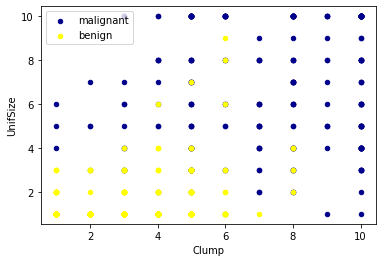

In [12]:
ax = cell_df[cell_df['Class'] == 4][0:699].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:699].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## Checking the corelation in the data

Text(33.0, 0.5, 'Features')

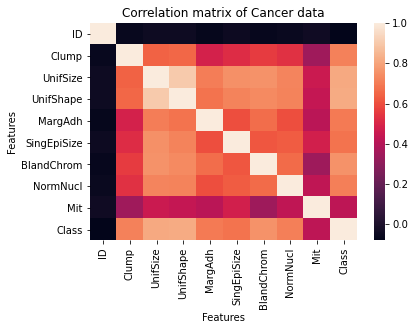

In [13]:
cell_df.corr()
sns.heatmap(cell_df.corr())
plt.title("Correlation matrix of Cancer data")
plt.xlabel('Features')
plt.ylabel('Features')

## Plotting the distribution of the data
We will try to see how the malignant and benign tumors are distributed in the dataset.
In short we will try to see how the count plot looks for the Data Distribution.


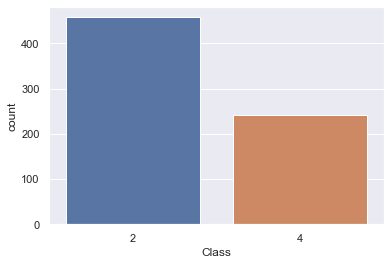

In [14]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Class", data=cell_df)

## Data pre-processing and selection

Lets first look at columns data types, so that we can categorize the numerical and categorical variables

In [15]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int32
dtype: object

It looks like the __BareNuc__ column includes some values that are not numerical.Lets look into the Unique values,
If the values are Garbage or are Chars we can drop that.

In [16]:
cell_df['BareNuc'].unique()


array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

Looks Like we just have "?" as a garbage value in data set , so lets delete the "?" from datasets

In [17]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int32
dtype: object

In [18]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)


We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [19]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])

## Train/Test dataset
We will split the train and test data into 80% : 20% ratio <br/>
1.) Test Data - 20% <br/>
2.) Train Data -80 % <br/>

In [20]:
#Okay, we split our dataset into train and test set:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
print('Train Data',X_train.shape, y_train.shape)
print('Test Data',X_test.shape,y_test.shape)

Train Data (546, 9) (546,)
Test Data (137, 9) (137,)


# Create Hyperparameter using Randomized search CV on Random Forest
Since we canntot train the model on the default parameters, It is always a good practice to train the model on the Hyperparameter tuned Model.

We will be using  combination of randomized search cv and grid search CV to tune the model on the random forest model
The Parameters we will be tuning are:

1. n_estimators
2. max_features
3. max_depth
4. min_samples_split
5. min_samples_leaf
6. random_grid


In [21]:
#Randomized Serch CV
#No of trees in RF
n_estimators= [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
#No of faetures
max_features=['auto', 'sqrt','log2']
#Max depth for a RF
max_depth=[int(x) for x in np.linspace(10,30,3)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
#min sample in each leaf node
min_samples_leaf = [1, 2, 4,6,8]
#Create a dictonary of a random_grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)


{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


### Performing Randomized Search CV
we will use k-fold cross validation technique in terms of running the model for different cross validation

In [22]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,random_state=100,n_jobs=1)
rf_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini, total=   0.9s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini, total=   1.0s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=10, criterion=gini, total=   0.9s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=entropy, total=   0.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=entropy, total=   0.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=entropy 
[CV]  n_estim

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=6, max_features=sqrt, max_depth=10, criterion=entropy, total=   1.1s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=30, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=30, criterion=gini, total=   1.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=30, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=30, criterion=gini, total=   0.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=30, criterion=gini 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=8, max_features=log2, max_depth=30, criterion=gini, total=   0.9s
[CV] n_estimators=300, min_samples_split=14, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=gini 
[CV]  n_estimators=300, min_sam

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, criterion=entropy, total=   1.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, criterion=entropy 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, criterion=entropy, total=   1.3s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, criterion=entropy 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=20, criterion=entropy, total=   1.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, criterion=gini 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, criterion=gini, total=   1.2s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, criterion=gini 
[CV]  n_estim

[CV]  n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=10, criterion=gini, total=   0.3s
[CV] n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=10, criterion=gini 
[CV]  n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=10, criterion=gini, total=   0.3s
[CV] n_estimators=500, min_samples_split=14, min_samples_leaf=4, max_features=log2, max_depth=30, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=14, min_samples_leaf=4, max_features=log2, max_depth=30, criterion=entropy, total=   1.5s
[CV] n_estimators=500, min_samples_split=14, min_samples_leaf=4, max_features=log2, max_depth=30, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=14, min_samples_leaf=4, max_features=log2, max_depth=30, criterion=entropy, total=   1.5s
[CV] n_estimators=500, min_samples_split=14, min_samples_leaf=4, max_features=log2, max_depth=30, criterion=entropy 
[CV]  n_estim

[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=20, criterion=gini, total=   0.8s
[CV] n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=gini 
[CV]  n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=gini, total=   0.3s
[CV] n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=gini 
[CV]  n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=gini, total=   0.4s
[CV] n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=gini 
[CV]  n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=gini, total=   0.3s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=8, max_features=log2, max_depth=10, criterion=entropy 
[CV]  n_estimators=500, mi

[CV]  n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=entropy, total=   0.3s
[CV] n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=entropy 
[CV]  n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=entropy, total=   0.3s
[CV] n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=entropy 
[CV]  n_estimators=100, min_samples_split=14, min_samples_leaf=1, max_features=log2, max_depth=30, criterion=entropy, total=   0.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=20, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=20, criterion=entropy, total=   0.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=log2, max_depth=20, criterion=entropy 
[CV]  n

[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, criterion=entropy, total=   1.8s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, criterion=entropy 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, criterion=entropy, total=   1.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=gini 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=gini, total=   0.9s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=gini 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=gini, total=   0.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=gini 
[CV]  n_estimators=200, 

[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=8, max_features=log2, max_depth=30, criterion=entropy, total=   0.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy, total=   0.9s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy, total=   1.0s
[CV] n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy, total=   0.8s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=20, criterion=gini 
[CV]  n_estim

[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy, total=   0.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy, total=   0.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=30, criterion=entropy, total=   0.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=gini 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=gini, total=   1.8s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, criterion=gini 
[CV]  n_estimato

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=100, verbose=2)

### Best parameter selection
When the Randomized Search CV runs it runs for multiple iterations and we need to get the best results or the parameters so that our algorith performs in the most efficient way. for the we use "rf_randomcv.best_estimator_"

In [23]:
#Best Parameter in randomized serach
best_grid=rf_randomcv.best_estimator_
best_grid

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=500)

### Creating the metrics after the Randomized search CV

In [25]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
y_pred=best_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print('accuracy',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[86  4]
 [ 0 47]]
accuracy 0.9708029197080292
              precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137



### Performing Grid search ther the trained parmeters from Randomized Search
We will ber performing grid search over the trained parameters from Randomized Search.
We will create a search space for the grid search parameters by taking the Best randomized search CV as the baseline parameters.

In [26]:
from sklearn.model_selection import GridSearchCV
#Create Param Dict
param_grid_1 = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         rf_randomcv.best_params_['min_samples_leaf']+2, 
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'], 
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 200, rf_randomcv.best_params_['n_estimators'] - 100, 
                     rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] + 100, rf_randomcv.best_params_['n_estimators'] + 200]
}
param_grid_1

{'criterion': ['gini'],
 'max_depth': [10],
 'max_features': ['auto'],
 'min_samples_leaf': [4, 6, 8],
 'min_samples_split': [8, 9, 10, 11, 12],
 'n_estimators': [300, 400, 500, 600, 700]}

In [27]:
rf=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid_1,cv=10,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.1s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600, total=   1.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600, total=   1.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600, total=   1.8s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=600 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=400, total=   1.1s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=500, total=   1.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=500 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.8s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.8s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300, total=   0.8s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   1.7s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   2.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600, total=   1.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700, total=   2.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=11, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=11, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=11, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=11, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=11, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=11, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=11, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=11, n_estimators=500 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.1s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=600, total=   2.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=700, total=   2.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=700, total=   2.1s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=700, total=   2.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=700 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=500, total=   1.7s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=500, total=   1.8s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=500, total=   1.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=500, total=   1.7s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=8, n_estimators=500 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=400 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=700, total=   2.3s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=700, total=   2.3s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=700, total=   2.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=700, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=9, n_estimators=700 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500, total=   2.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=500 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=300, total=   1.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=400, total=   1.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=400, total=   1.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=400, total=   1.3s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=400 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=700, total=   2.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=700, total=   2.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=700, total=   2.3s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=700, total=   2.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=11, n_estimators=700 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=12, n_estimators=500, total=   2.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=12, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=12, n_estimators=500, total=   1.7s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=12, n_estimators=500 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=12, n_estimators=500, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=12, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=12, n_estimators=600, total=   2.1s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=6, min_samples_split=12, n_estimators=600 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=400, total=   1.3s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=400 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=700, total=   2.7s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=700, total=   2.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=700, total=   2.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=700, total=   2.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=8, n_estimators=700 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=500, total=   1.8s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=600, total=   2.0s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=600, total=   1.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=600, total=   2.1s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=9, n_estimators=600 
[CV]  criterion=gini, max_depth=10, 

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   1.3s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   1.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   1.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400, total=   1.3s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=400 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=700, total=   2.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=700, total=   2.2s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=700 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=700, total=   2.4s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=300 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=300, total=   0.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=300 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=600, total=   1.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=600, total=   1.9s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=600, total=   2.1s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=600 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=600, total=   2.1s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=11, n_estimators=600 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=400, total=   1.3s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=400, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=400, total=   1.6s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=400 
[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=400, total=   1.5s
[CV] criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=400 
[CV]  criterion=gini, max_de

[CV]  criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=12, n_estimators=700, total=   2.6s


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed: 20.4min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [10],
                         'max_features': ['auto'],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [8, 9, 10, 11, 12],
                         'n_estimators': [300, 400, 500, 600, 700]},
             verbose=2)

### Getting Best Parameters for grid search

In [28]:
best_grid_1=grid_search.best_estimator_
best_grid_1

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300)

# RESULT
After the grid serach is performed , we create the metrics to decide how good our classification looks like.
We took in account Recall criteria to detrmine our net result.
1. Recall = (tp/tp+fn)
   - tp : true positive
   - fp : false negative

In [30]:
y_pred=best_grid_1.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[86  4]
 [ 0 47]]
Accuracy Score 0.9708029197080292
Classification report:               precision    recall  f1-score   support

           2       1.00      0.96      0.98        90
           4       0.92      1.00      0.96        47

    accuracy                           0.97       137
   macro avg       0.96      0.98      0.97       137
weighted avg       0.97      0.97      0.97       137

